In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("/kaggle/input"))

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math
import gc

In [ ]:
train = pd.read_csv('../input/train.csv', nrows=5000000)
test = pd.read_csv('../input/test.csv')
train.head()

Delete all missing values because there are only few out of millions of data points . Dont drop from test data.

In [ ]:
print(train.isnull().sum())
train = train.dropna(how='any',axis=0)

Find out absolute difference between longitudes and latitudes which could relate to distance.

In [ ]:
train['abs_diff_longitude'] = np.abs(train['dropoff_longitude'] - train['pickup_longitude'])
train['abs_diff_latitude'] = np.abs(train['dropoff_latitude'] - train['pickup_latitude'])
test['abs_diff_longitude'] = np.abs(test['dropoff_longitude'] - test['pickup_longitude'])
test['abs_diff_latitude'] = np.abs(test['dropoff_latitude'] - test['pickup_latitude'])

Plot different variables and see what we can get.

In [ ]:
# sns.relplot(x='passenger_count',y='fare_amount',data=train.iloc[:1000,:],kind='scatter')
sns.countplot(x='passenger_count',data=train.iloc[:1000,:])
sns.relplot(x='abs_diff_longitude', y="fare_amount",data=train.loc[:1000,:])
sns.relplot(x="abs_diff_latitude", y='fare_amount',data=train.loc[:1000,:])


* some have negative fare_amount.
* some obs have more passenger count(>6) and still fare_amount is 0.
* some obs have 0 passenger_count
* outliers are making visualisation very difficult, remove them
* clearly many have false data so delete it.
* most of the passengers travel alone

In [ ]:
train = train.loc[train['fare_amount']>0,:]
train = train.loc[(train["passenger_count"]<=6) & (train["passenger_count"]>0),:]
train = train.loc[(train["abs_diff_latitude"]<2) & (train["abs_diff_longitude"]<2),:]

Minimum fare is 2.5 in NY, so drop outliers.

In [ ]:
train = train[train['fare_amount'].between(left = 2.5, right = 100)]

Now plot them again and check to see any changes.

In [ ]:
# sns.relplot(x='passenger_count',y='fare_amount',data=train,kind='scatter')
sns.countplot(x='passenger_count',data=train.iloc[:1000000,:])
# f,ax = plt.subplots(1,2,figsize=(18,8))
sns.relplot(x='abs_diff_longitude', y="fare_amount",data=train.loc[:1000,:])
sns.relplot(x="abs_diff_latitude", y='fare_amount',data=train.loc[:1000,:])

We'll split timestamp and key column so that we can perform groupby operations on key.

In [ ]:
train.loc[:,'timestamp_with_key'] = train.loc[:,'key'] 
test.loc[:,'timestamp_with_key'] = test.loc[:,'key']
train.key = pd.DataFrame({'key':train['key'].str.split('.').str[1].astype('int')})
test.key = pd.DataFrame({'key':test['key'].str.split('.').str[1].astype('int')})

In [ ]:
# #using datetime try to analyse is there cor b/w time and price (you could get time windows
# #(divide a day into 8 parts) and add that feature and see cor b/w time and price)
# from math import floor
# def chooseSlot(x):
#     hr = x.hour
#     return int(hr/3 + 1)

# train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], infer_datetime_format=True).dt.tz_localize('UTC')
# test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], infer_datetime_format=True).dt.tz_localize('UTC')
# train['time_slot'] = pd.DataFrame(list(map(lambda x : chooseSlot(x), train['pickup_datetime'][:])), index=train.index)
# test['time_slot'] = pd.DataFrame(list(map(lambda x : chooseSlot(x), test['pickup_datetime'][:])), index=test.index)

Using datetime data create features for hour, weekday, year, so that we could analyse correlation between time and fare_amount.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], infer_datetime_format=True).dt.tz_localize('UTC')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], infer_datetime_format=True).dt.tz_localize('UTC')
train.loc[:,'hour_no'] = train['pickup_datetime'][:].dt.strftime('%-H').astype('int')
test.loc[:,'hour_no'] = test['pickup_datetime'][:].dt.strftime('%-H').astype('int')
train.loc[:,'weekday_no'] = train['pickup_datetime'][:].dt.strftime('%w').astype('int')
test.loc[:,'weekday_no'] = test['pickup_datetime'][:].dt.strftime('%w').astype('int')
train.loc[:,'day_no'] =  train['pickup_datetime'][:].dt.strftime('%-d').astype('int')
test.loc[:,'day_no'] = test['pickup_datetime'][:].dt.strftime('%-d').astype('int')
train.loc[:,'year_no'] = train['pickup_datetime'][:].dt.strftime('%-y').astype('int')
test.loc[:,'year_no'] = test['pickup_datetime'][:].dt.strftime('%-y').astype('int')

The column Key indicates the ids of the taxis not customers!!. So anything directly related to customers cant be obtained such as:
To check if fares decreases or increases for frequent customers based on distance and datetime.

Visualize how taxi counts vary according to date and time.

In [ ]:
sns.countplot(x='hour_no',data=train.loc[:1000,:])
# sns.countplot(x='weekday_no',data=train.loc[:1000,:])
# sns.countplot(x='year_no',data=train.loc[:1000,:])

In [ ]:
# def eucledian(x):
#     dist = np.sqrt( np.power(x[0]-x[2],2) + np.power(x[1]-x[3],2))
#     return dist

# train['dist_eucledian'] = pd.DataFrame(list(
#     map(lambda x: eucledian(x), train[["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]].values)),
#                                       index=train.index)

Actually Eucledian distance doesn't make any sense as lat and log is in degrees. In order to obtain distance in meters, miles (used kilometer here) use Haversine distance measure.

In [ ]:
def dist_haversine(x):
    R = 6371 #for metres 6371e3
    picklat = math.radians(x[1])
    droplat = math.radians(x[3])
    latdiff = abs(droplat-picklat)
    picklon = math.radians(x[0])
    droplon = math.radians(x[2])
    londiff = abs(droplon-picklon)

    a = math.sin(latdiff/2) * math.sin(latdiff/2) +\
            math.cos(picklat) * math.cos(droplat) *\
            math.sin(londiff/2) * math.sin(londiff/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return (R * c)

train['dist_haversine_km'] = pd.DataFrame(list(
    map(lambda x: dist_haversine(x), train[["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]].values)),
                                      index=train.index)

test['dist_haversine_km'] = pd.DataFrame(list(
    map(lambda x: dist_haversine(x), test[["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]].values)),
                                      index=test.index)


As there map() is used calculation takes long time. If there is better way let me know.

In [ ]:
# train['dist_haversine_km'] = 1
# for i in range(9):
#     train['dist_haversine_km'][(i*1000000):((i+1) * 1000000)] = pd.DataFrame(list(
#         map(lambda x: dist_haversine(x),
#             train[["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]][(i*1000000):((i+1) * 1000000)].values)))
                                                                             
# # ),index=train.index[(i*1000000):((i+1) * 1000000)].reshape(len(train.index[(i*1000000):((i+1) * 1000000)]),1)
                                                                             
# train['dist_haversine_km'][(i*1000000):] = pd.DataFrame(list(
#     map(lambda x: dist_haversine(x),
#         train[["pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude"]][(i*1000000):].values)))
# # ),index=train.index[(i*1000000):].reshape(len(train.index[(i*1000000):]),1)

Lets create features based on price per distance and also per passenger.

In [ ]:
train['fare_per_km'] = train['fare_amount']/(train["dist_haversine_km"])
train['fare_per_km_passenger'] = train['fare_amount']/(train['dist_haversine_km']*train['passenger_count'])

In [ ]:
train.groupby('key').agg({'fare_per_km_passenger':'mean','key':'count','passenger_count':'mean','fare_amount':'mean'})

How come fare_per_km_passenger values are so high, this makes no sense because some rides have very high fare so mean would be more than expected. Lets check whats happening.

In [ ]:
train.loc[train['fare_per_km_passenger']>20,['fare_per_km_passenger','fare_amount','dist_haversine_km']]
# train[['fare_per_km_passenger','fare_amount','dist_haversine_km','passenger_count']][30:60]

we are getting so high fare/km/passenger not just because some observations have wrong data but also because we are calculating fare/km, when haversine dist is less than one km it is increasing the fare prices to calculate per km. 
So what we know now is, for very short distances they charge more than actual price (particularly if the distance is less than a kilometer, because even if the prices are extrapolated to kilometer, prices shouldn't have been so high).

Now lets analyse indivisual keys to know which time slots have high prices.

In [ ]:
grouped_df = train.groupby('key')
count = 0
for key, item in grouped_df:
    count += 1
    if count == 2: ## to view key = 2
        filtered = grouped_df.get_group(key)["dist_haversine_km"]>1 #ignoring drives within 1km
        df = pd.DataFrame(grouped_df.get_group(key).loc[filtered,:].sort_values(by='pickup_datetime'))
#         print(grouped_df.get_group(key)[['pickup_datetime','fare_per_km_passenger']][grouped_df.get_group(key)["dist_haversine_km"]>1].describe())
        break

indexes = ['key',df['pickup_datetime'].dt.strftime('%a'),'hour_no']
grouped = df[:][:].groupby(indexes).agg({'fare_per_km_passenger':'mean','fare_per_km':'mean','fare_amount':'count'}) 
grouped.rename(columns={'fare_amount':'count'},inplace=True)
grouped

In [ ]:
reindexed = grouped.reset_index().drop('key',axis=1)
get_max_count = reindexed.groupby(['pickup_datetime']).agg({'count':'max'})
get_max_count = get_max_count.reindex(reindexed['pickup_datetime'], method='ffill')
reindexed = reindexed.set_index('pickup_datetime')
reindexed.loc[get_max_count['count'] == reindexed['count'],:]

In [ ]:
del reindexed, grouped, get_max_count, grouped_df

* Number of taxi drives are more during night time. But Fares are high between  9am to 3pm.

Delete some of the possible outliers such as, data with distance is more than kilometer but fare amount is less and vice-versa.

In [ ]:
#train.loc[ ((train['fare_per_km']<0.2) & (train['dist_haversine_km']>1))]
train = train.loc[ ~ (((train['dist_haversine_km']>1) & train['fare_per_km']<0.2))]
train = train.loc[~ ((train['dist_haversine_km']<0.01) & (train['fare_per_km']>50))]

We cannot use fare_per_km_passenger for training bcuz it is dependent on fare_amount(target variable). we used it just to check how hour_no and haversine distance correlate with taxi fares.

In [ ]:
train = train.drop(['fare_per_km_passenger','fare_per_km'],axis=1)

There is something wrong here, latitudes and longitudes of New york are around 40 and -73 respectively.Lets check how many have wrong values. We'll drop observations that have location values way out of new york.

In [ ]:
# train['pickup_latitude'].shape[0] - train['pickup_latitude'].between(40,41).sum()
# print(train.shape[0] - train.loc[train['pickup_latitude'].between(40.5,41) & train['dropoff_latitude'].between(40.5,41) &
#           train['pickup_longitude'].between(-74,-73.9) &  train['dropoff_longitude'].between(-74,-73.9)].shape[0])
# old_train = train.copy()

train = train.loc[train['pickup_latitude'].between(40, 42)]
train = train.loc[train['pickup_longitude'].between(-75, -72)]
train = train.loc[train['dropoff_latitude'].between(40, 42)]
train = train.loc[train['dropoff_longitude'].between(-75, -72)]

# train = train.loc[train['pickup_latitude'].between(40.5,41) & train['dropoff_latitude'].between(40.5,41) &
#                   train['pickup_longitude'].between(-74,-73.9) &  train['dropoff_longitude'].between(-74,-73.9)]
# dont alter test data

Now lets try to divide the whole new york into 100 places and get correlation b/w places and prices.This can be using pd.cut() on train set and use the same bins of train set to cut test set. Similar to fit-transform on train and transform on test.

In [ ]:
train.loc[:,'pickuplat_no'], pick_lat_bin = pd.cut(train['pickup_latitude'],100, labels=False, retbins=True)
train.loc[:,'pickuplong_no'], pick_long_bin = pd.cut(train['pickup_longitude'],100, labels=False, retbins=True)
train.loc[:,'dropofflat_no'], drop_lat_bin = pd.cut(train['dropoff_latitude'],100, labels=False, retbins=True)
train.loc[:,'dropofflong_no'], drop_long_bin = pd.cut(train['dropoff_longitude'],100, labels=False, retbins=True)
test['pickuplat_no'] = pd.cut(test['pickup_latitude'], pick_lat_bin, labels=False).fillna(int(train.loc[:,'pickuplat_no'].mean()))
test['pickuplong_no'] = pd.cut(test['pickup_longitude'], pick_long_bin, labels=False).fillna(int(train.loc[:,'pickuplong_no'].mean()))
test['dropofflat_no'] = pd.cut(test['dropoff_latitude'], drop_lat_bin, labels=False).fillna(int(train.loc[:,'dropofflat_no'].mean()))
test['dropofflong_no'] = pd.cut(test['dropoff_longitude'], drop_long_bin, labels=False).fillna(int(train.loc[:,'dropofflong_no'].mean()))

As all those above created features points to specific locations of New York, if we take difference it could relate to distance as well.

In [ ]:
train.loc[:,'pickdrop_lat_diff'] = abs(train['pickuplat_no'].astype(int) - train['dropofflat_no'].astype(int))
train.loc[:,'pickdrop_long_diff'] = abs(train['pickuplong_no'].astype(int) - train['dropofflong_no'].astype(int))
train.loc[:,'final_dist_factor'] = (train['pickdrop_lat_diff'].astype(int) + train['pickdrop_long_diff'].astype(int))
test.loc[:,'pickdrop_lat_diff'] = abs(test['pickuplat_no'].astype(int) - test['dropofflat_no'].astype(int))
test.loc[:,'pickdrop_long_diff'] = abs(test['pickuplong_no'].astype(int) - test['dropofflong_no'].astype(int))
test.loc[:,'final_dist_factor'] = (test['pickdrop_lat_diff'].astype(int) + test['pickdrop_long_diff'].astype(int))

Group by latitudes and longitudes based on count to see crowded area, and assign crowd factor 1 for most crowded area and 2 for next most crowded area and so on. (To see groupby data uncomment below). 
If count at a particular region is same as other region allocate same crowd factor for both.

In [ ]:
#  train.groupby('pickuplat_no')['key'].count().sort_values(ascending=False).reset_index()

In [ ]:
def calc_cwd_factor(df, col):
    new_df = df.groupby(col)['key'].count().sort_values(ascending=False).reset_index()
    new_df['cwd_factor'] = 1
    count = 1
    for i in range(1,new_df.shape[0]):
        count += 1
        if new_df.loc[i-1,'key'] == new_df.loc[i,'key']:
            count -= 1
        new_df.loc[i,'cwd_factor'] = count
    new_df.index = new_df[col]
    return new_df

fact_df = calc_cwd_factor(train, 'pickuplat_no')
train.loc[:,'pickuplat_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], train['pickuplat_no']))
fact_df = calc_cwd_factor(train, 'pickuplong_no')
train.loc[:,'pickuplong_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], train['pickuplong_no']))
fact_df = calc_cwd_factor(train, 'dropofflat_no')
train.loc[:,'dropofflat_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], train['dropofflat_no']))
fact_df = calc_cwd_factor(train, 'dropofflong_no')
train.loc[:,'dropofflong_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], train['dropofflong_no']))
#do the same for test set:
fact_df = calc_cwd_factor(test, 'pickuplat_no')
test.loc[:,'pickuplat_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], test['pickuplat_no']))
fact_df = calc_cwd_factor(test, 'pickuplong_no')
test.loc[:,'pickuplong_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], test['pickuplong_no']))
fact_df = calc_cwd_factor(test, 'dropofflat_no')
test.loc[:,'dropofflat_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], test['dropofflat_no']))
fact_df = calc_cwd_factor(test, 'dropofflong_no')
test.loc[:,'dropofflong_cwd_factor'] = list(map(lambda x: fact_df.loc[x,'cwd_factor'], test['dropofflong_no']))
del fact_df

In [ ]:
print(train.shape,test.shape)

Let me know in the comments if there are any suggestions. 

In [ ]:
gc.collect()

In [ ]:
import sklearn
from sklearn import *
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [ ]:
# orig_train = train.copy()
# orig_test = test.copy()
# train = orig_train.copy()
# test = orig_test.copy()

In [ ]:
train = shuffle(train.iloc[:,:]).reset_index(drop=True)
val = train.iloc[int(0.9*train.shape[0]):,:]
train = train.iloc[:int(0.9*train.shape[0]),:]

# scaler = StandardScaler().fit(train.loc[:,train_cols])
# train.loc[:,train_cols] = scaler.transform(train.loc[:,train_cols])
# val.loc[:,train_cols] = scaler.transform(val.loc[:,train_cols])         
# test.loc[:,test_cols] = scaler.transform(test.loc[:,test_cols])

# cols_to_normalize = ['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
#               'abs_diff_longitude', 'abs_diff_latitude', 'dist_haversine_km']
# transformer = Normalizer().fit(train.loc[:,cols_to_normalize])
# train.loc[:,cols_to_normalize] = transformer.transform(train.loc[:,cols_to_normalize])
# val.loc[:,cols_to_normalize] = transformer.transform(val.loc[:,cols_to_normalize])         
# test.loc[:,cols_to_normalize] = transformer.transform(test.loc[:,cols_to_normalize])

Lets do some **feature selection** or atleast know which features are very important.
* correlations - heatmaps 
* shuffling columns and seeing accuracies

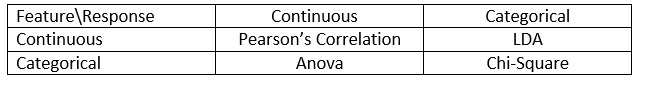 All we need now is Pearson correlation and Anova

In [ ]:
#pearson correlation:
import seaborn as sns

object_cols = ['key','pickup_datetime','timestamp_with_key']

categorical_cols = ['passenger_count', 'hour_no', 'weekday_no', 'day_no', 'year_no', 'pickuplat_no', 'pickuplong_no',
'dropofflat_no', 'dropofflong_no', 'pickdrop_lat_diff', 'pickdrop_long_diff', 'final_dist_factor',
'pickuplat_cwd_factor', 'pickuplong_cwd_factor', 'dropofflat_cwd_factor', 'dropofflong_cwd_factor']

numerical_cols =['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude',
'abs_diff_longitude', 'abs_diff_latitude', 'dist_haversine_km']

target = ['fare_amount']

cor = train.loc[:,numerical_cols+target]
f, ax = plt.subplots(1,1,figsize=(18,7))
sns.heatmap(cor.corr(), annot=True)

In [ ]:
gc.collect()

In [ ]:
#f_regression,
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

f_reg = f_regression(train[categorical_cols+numerical_cols],train['fare_amount'], center=True)
mir_c = mutual_info_regression(train[categorical_cols][:10000],  train['fare_amount'][:10000])
mir_n = mutual_info_regression(train[numerical_cols][:10000],  train['fare_amount'][:10000])

impt_cols_freg = list(zip(f_reg[0], categorical_cols+numerical_cols ))
impt_cols_freg = sorted(impt_cols_freg, key = lambda x:x[0], reverse=True)
impt_cols_c = list(zip(mir_c ,categorical_cols))
impt_cols_c = sorted(impt_cols_c, key = lambda x:x[0], reverse=True)
impt_cols_n = list(zip(mir_n ,numerical_cols))
impt_cols_n = sorted(impt_cols_n, key = lambda x:x[0], reverse=True)

In [ ]:
drop_cols = []
for i in impt_cols_c[-8:]:
    drop_cols.append(i[1])
train = train.drop(drop_cols, axis=1)
test = test.drop(drop_cols, axis=1)

In [ ]:
gc.collect()

In [ ]:
train_y = train['fare_amount'][:]
val_y = val['fare_amount'][:]
cols = [i for i in train.columns if i not in ['fare_amount'] + object_cols]
train_x = train.loc[:, cols]
val_x = val.loc[:, cols]
test_x = test.loc[:,cols]
# print(train.columns, train.shape)
# print(val.columns, val.shape)
# print(test.columns, test.shape)

In [ ]:
del train, val

In [ ]:
# import xgboost as xgb
# from xgboost import XGBRegressor

# xgbr = XGBRegressor()
# xgb_train = xgbr.fit(train_x, train_y)

# pred_train = xgbr.predict(train_x).round(decimals = 2)
# pred_val = xgbr.predict(val_x).round(decimals = 2)
# pred_test = xgbr.predict(test_x).round(decimals = 2)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# #xgbr = XGBRegressor()
# params = {
#         'nthread': [4],
#         'num_leaves': [30, 35, 40],
#         'learning_rate': [0.03, 0.05, 0.08], 
# #         'max_depth': [],
#         'subsample': [0.8],
#         'bagging_fraction' : [1],
#         'max_bin' : [5000] ,
#         'bagging_freq': [20],
#         'colsample_bytree': [0.6],
#         'metric': ['rmse'],
#         'min_split_gain': [0.5],
#         'min_child_weight': [1],
#         'min_child_samples': [10],
#         'scale_pos_weight':[1],
#         'seed':[0],
#         'num_rounds':[50000]
#     }
# xgb_grid = GridSearchCV(xgbr,
#                         params,
#                         n_jobs = 4,
#                         verbose=True)

# xgb_grid.fit(train_x, train_y)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)

# pred_train = xgbr_grid.predict(train_x).round(decimals = 2)
# pred_val = xgbr_grid.predict(val_x).round(decimals = 2)
# pred_test = xgbr_grid.predict(test_x).round(decimals = 2)

In [ ]:
import lightgbm as lgbm

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000
    }
cols = list(train_x.select_dtypes(exclude=['float64']).columns)

train_set = lgbm.Dataset(train_x, train_y, silent=False,categorical_feature=cols)
valid_set = lgbm.Dataset(val_x, val_y, silent=False,categorical_feature=cols)

model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)

In [ ]:
pred_train = model.predict(train_x, num_iteration = model.best_iteration)#.round(decimals = 2)
pred_val = model.predict(val_x, num_iteration = model.best_iteration)#.round(decimals = 2)
pred_test = model.predict(test_x, num_iteration = model.best_iteration)#.round(decimals = 2)

In [ ]:
gc.collect()

In [ ]:
from sklearn.metrics import mean_squared_error
rmse_train = np.sqrt(mean_squared_error(train_y, pred_train))
rmse_val = np.sqrt(mean_squared_error(val_y, pred_val))
print(rmse_train, rmse_val)

Shuffling each column data and seeing final rmse on validation to see how much value each column is adding for predicting target variable.

In [ ]:
# import eli5
# from eli5.sklearn import PermutationImportance

# perm = PermutationImportance(lgbm, random_state=1).fit(val_x, val_y)
# eli5.show_weights(perm, feature_names = val_x.columns.tolist())

In [ ]:
final = pd.DataFrame({'key':test.timestamp_with_key, 'fare_amount':pred_test}, columns = ['key', 'fare_amount'])
final.to_csv('submission_lgb.csv', index = False)
final.head()